___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://facts.net/wp-content/uploads/2023/07/ASL-finger-signs--2048x1365.jpg" width="400px" height="180px" />


# <font color= #bbc28d> **PROYECTO FINAL** </font>
#### <font color= #2E9AFE> `Clasificación de Imágenes con Redes Neuronales`</font>
- <Strong> Diana Valdivia, Samantha Sánchez, Óscar Rocha, Viviana Toledo </Strong>
- <Strong> Fecha </Strong>: 18/05/2025



___

<p style="text-align:right;"> Imagen recuperada de: https://facts.net/wp-content/uploads/2023/07/ASL-finger-signs--2048x1365.jpg</p>

In [93]:
# Librerías Generales
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import requests
from io import BytesIO

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.image as mpimg

# Preprocesamiento
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Modelado - Redes Neuronales
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
# import tensorflow_hub as hub

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# <font color= #bbc28d> **Introducción** </font>

La lengua de señas es una herramienta esencial para la comunicación e inclusión de personas sordomudas, pues es el principal medio en el que pueden transmitir sus ideas y **hacerse escuchar** a través del cuerpo. Sin embargo, no todas las personas hablan este idioma y los signos varían según la región, lo que complica el proceso de aprendizaje y comprensión de la lengua de señas. 

Lo anterior resalta la necesidad de producir herramientas que faciliten la traducción del idioma, que interpreten las señas y permitan **cruzar la brecha lingüística** para no solo fomentar el uso de la lengua de señas, sino también eficientar el proceso de interpretación.

# <font color= #bbc28d> **Objetivo** </font>

- Elaborar una red neuronal capaz de identificar 3 letras del alfabeto de la Lengua de Señas Americana (ASL) a partir de una serie de imágenes, con la intención de traducir las señas y evaluar la posibilidad de escalar el modelo para el idioma en general.

# <font color= #bbc28d> **Análisis Exploratorio de Datos** </font>

Los datos para la elaboración de nuestro modelo fueron obtenidos de Kaggle, en la siguiente liga: https://www.kaggle.com/datasets/grassknoted/asl-alphabet?resource=download. 

El dataset contiene $3,000$ imágenes de $200 \times  200$ pixeles por cada letra del alfabeto ASL, así como para _Espacio_, _Borrar_ y _Nada_. Lo anterior resulta en un dataset de $29$ clases y $87,000$ imágenes, del cual, seleccionaremos tres señas para las letras **$S, U \space \text{e} \space Y$**, debido a las diferencias marcadas entre las señas para cada una.

## <font color= #84a7b3> **Visualizar las Señas** </font>

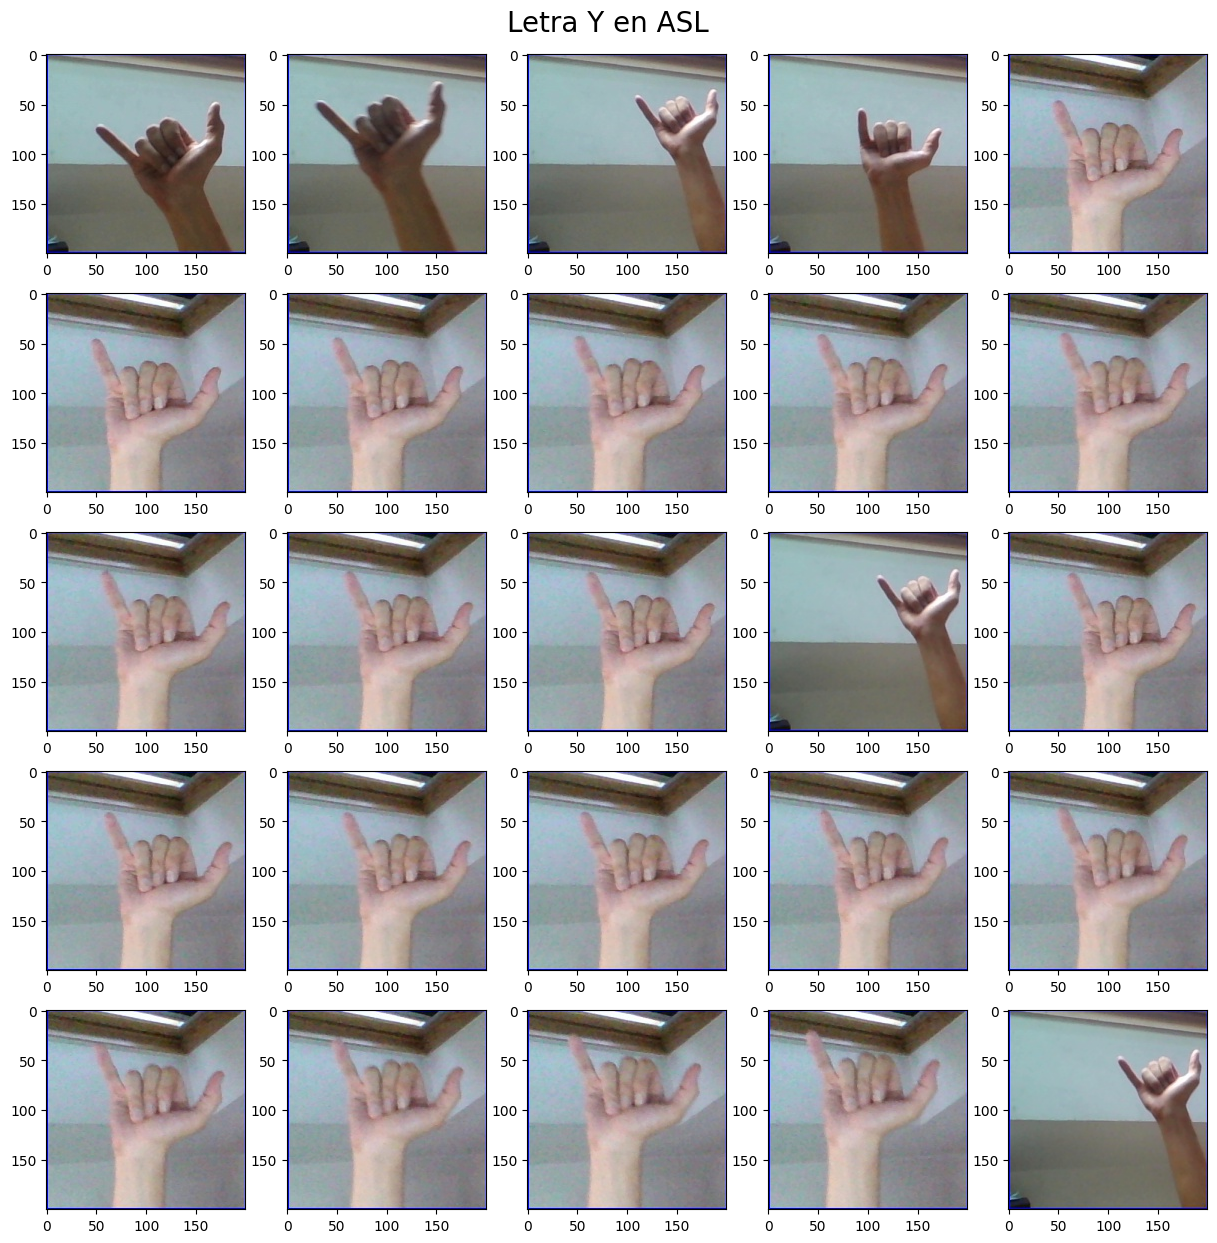

In [94]:
plt.figure(figsize=(15,15))
plt.suptitle('Letra Y en ASL', fontsize=20, y=0.91)

carpeta = 'data\Y'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

Explorando las imágenes disponibles en el dataset, podemos asumir que son fotografías tomadas de un vídeo o momento en el que se realizó la seña. Esto nos otorga diferentes ángulos y niveles de luz, sin embargo, también implica que hayan ciertas repeticiones o similitudes excesivas entre imágenes.

# <font color= #bbc28d> **Preprocesamiento** </font>

## <font color= #84a7b3> **Selección de Imágenes** </font>

Para evitar esperas largas en el entrenamiento de la red neuronal y evitar la similitud excesiva entre imágenes, seleccionaremos una muestra del $10 \% $ entre las $3,000$ fotografías disponibles.

In [96]:
def img_selection(carpeta_fuente, letra):
    # Acceder a las imágenes
    imagenes = os.listdir(carpeta_fuente)
    # Definir la carpeta destino
    carpeta_destino = f'data/dataset/letra_{letra}'
    # Crear la carpeta destino si no existe
    os.makedirs(carpeta_destino, exist_ok=True)

    # Iterar sobre cada imagen y obtener el nombre
    for nombreimg in imagenes:
        # Si la imagen es un múltiplo de 10, seleccionarla y copiarla a las imágenes seleccionadas
        if nombreimg[-5] == "0":
            shutil.copy(os.path.join(carpeta_fuente, nombreimg),
                        os.path.join(carpeta_destino, nombreimg))

# Ejecutar para S, U, Y
img_selection('data/S', 'S')
img_selection('data/U', 'U')
img_selection('data/Y', 'Y')    

In [97]:
#Mostrar cuantas imagenes tengo de cada categoria
print('Letras S:', len(os.listdir('data/dataset/letra_S' )))
print('Letras U:', len(os.listdir('data/dataset/letra_U' )))
print('Letras Y:', len(os.listdir('data/dataset/letra_Y' )))

Letras S: 300
Letras U: 300
Letras Y: 300


## <font color= #84a7b3> **Introducción de Ruido** </font>

In [98]:
#Crear el dataset generador que hace imagenes con transformaciones
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=15,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=15,
    zoom_range=0.2,
    validation_split=0.2
)

#Generadores para sets de entrenamiento y pruebas
# Se pide que sea estandarizado a 224x224
data_gen_train = datagen.flow_from_directory('data/dataset', target_size=(224,224),class_mode='categorical',
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_test = datagen.flow_from_directory('data/dataset', target_size=(224,224),class_mode='categorical',
                                                     batch_size=32, shuffle=False, subset='validation')

Found 720 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


# <font color= #bbc28d> **Modelado** </font>

In [99]:
# Inicializar la red neuronal
model = Sequential()

# Aplana la imagen 224x224x3 a un vector de 150528 elementos
model.add(Flatten(input_shape=(224, 224, 3)))

# Capa de inicio
model.add(Dense(16, activation='relu', input_shape=(224,224,3)))

# Capas ocultas
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='leaky_relu'))
model.add(Dense(32, activation='relu'))

# Capas de salida, con 3 neuronas por cada categoría final que tenemos
model.add(Dense(3, activation='softmax'))

# Definir los criterios del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [100]:
# Entrenar el modelo
history = model.fit(data_gen_train,
                   epochs=5, 
                   batch_size=30,
                   validation_data=data_gen_test,
                   )

Epoch 1/5


c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 6/23 ━━━━━━━━━━━━━━━━━━━━ 8s 521ms/step - accuracy: 0.2658 - loss: 7.2796

KeyboardInterrupt: 

### Modelado Mejor (espero)

In [ ]:
# Inicializar la red neuronal
model1 = Sequential()

# Capa de inicio con 32 neuronas
model1.add(Conv2D(32, (3,3), activation="relu",
           input_shape=(224, 224, 3)))

# Capas ocultas
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(128, (3,3), activation='relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(128, (3,3), activation='relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(128, (3,3), activation='relu'))
model1.add(MaxPooling2D((2,2)))
    # Aplanar las imágenes para la salida
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))

# Capas de salida
model1.add(Dense(3, activation='softmax'))

# Definir los criterios del modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Entrenar el modelo
history = model1.fit(data_gen_train,
                   epochs=12, 
                   batch_size=60,
                   validation_data=data_gen_test,
                   )

Epoch 1/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 805ms/step - accuracy: 0.3436 - loss: 1.1860 - val_accuracy: 0.3389 - val_loss: 1.0958
Epoch 2/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 768ms/step - accuracy: 0.3901 - loss: 1.0931 - val_accuracy: 0.4111 - val_loss: 1.0923
Epoch 3/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 775ms/step - accuracy: 0.4474 - loss: 1.0633 - val_accuracy: 0.6056 - val_loss: 0.9436
Epoch 4/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 770ms/step - accuracy: 0.5628 - loss: 0.9203 - val_accuracy: 0.6611 - val_loss: 0.7559
Epoch 5/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 775ms/step - accuracy: 0.7635 - loss: 0.5582 - val_accuracy: 0.7778 - val_loss: 0.4846
Epoch 6/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 766ms/step - accuracy: 0.8476 - loss: 0.3623 - val_accuracy: 0.9333 - val_loss: 0.2649
Epoch 7/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 907ms/step - accuracy: 0.8893 - loss: 0.2587 - val_accuracy: 0.8778 - val_loss: 0.3306
Epoch 8/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 821ms/step - accuracy: 0.8797 - loss: 0.2866 - val_accu

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step
Accuracy: 0.9444
Precision: 0.9458
Recall: 0.9444
F1 Score: 0.9442


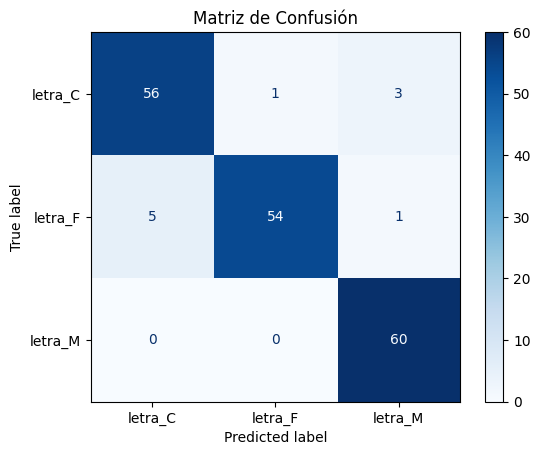

In [ ]:
# Obtener predicciones del modelo
y_pred_probs = model1.predict(data_gen_test)

# Pasar de probabilidades a etiquetas (el índice con mayor probabilidad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas verdaderas
y_true = data_gen_test.classes  

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Mostrar resultados
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar la matriz de confusión con etiquetas de clase
labels = list(data_gen_test.class_indices.keys())  # obtiene ['C', 'F', 'M']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()

# <font color= #bbc28d> **Validación** </font>

In [ ]:
# Categorizar una imagen de internet
def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = model1.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)


#0 = C, 1 = F, 2 = M
url = 'https://images2.pics4learning.com/catalog/c/c.jpg' #debe ser 0
prediccion = categorizar (url)
print(prediccion)


#0 = C, 1 = F, 2 = M
url = 'https://c8.alamy.com/comp/2GB4AFM/dramatic-bw-image-of-male-hand-demonstrating-asl-american-sign-language-letter-f-with-empty-copy-space-for-editors-2GB4AFM.jpg' #debe ser 1
prediccion = categorizar (url)
print(prediccion)

#0 = C, 1 = F, 2 = M
url = 'https://media.istockphoto.com/id/1682870731/photo/american-sign-language-letter-m-alphabet-with-child-kids-hand.jpg?s=612x612&w=0&k=20&c=WVx6vA6fjrneXFW5ciLZ3T6wCjlnvAvUOeOs-Fyunac=' #debe ser 2
prediccion = categorizar (url)
print(prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1


In [ ]:
#0 = C, 1 = F, 2 = M
url = 'https://bakerlogy.com/cdn/shop/products/LDN12841_ASLM_Fondant.jpg?v=1670522963&width=2400 ' #debe ser 2
prediccion = categorizar (url)
print(prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1


In [ ]:
#0 = C, 1 = F, 2 = M
url = 'https://static8.depositphotos.com/1571321/1053/v/950/depositphotos_10531819-stock-illustration-sketch-of-sign-language-hand.jpg' #debe ser 2
prediccion = categorizar (url)
print(prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1


In [ ]:
#0 = C, 1 = F, 2 = M
url = 'https://thumbs.dreamstime.com/b/little-finger-spelling-alphabet-american-sign-language-37694099.jpg' #debe ser 0
prediccion = categorizar (url)
print(prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2


### Validación nuevas imágenes desde carpeta

In [ ]:
# Reescala los tamaños de las imágenes
test_datagen = ImageDataGenerator(rescale=1./255)

data_gen_new_test = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 30 images belonging to 3 classes.


c:\Users\Vivienne\anaconda3\envs\iteso\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Accuracy: 0.4667
Precision: 0.6114
Recall: 0.4667
F1 Score: 0.4356


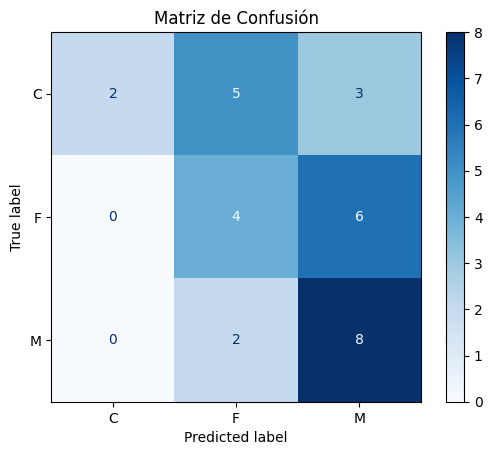

In [ ]:
# Obtener predicciones del modelo
y_pred_probs = model1.predict(data_gen_new_test)

# Pasar de probabilidades a etiquetas (el índice con mayor probabilidad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas verdaderas
y_true = data_gen_new_test.classes  

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Mostrar resultados
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar la matriz de confusión con etiquetas de clase
labels = list(data_gen_new_test.class_indices.keys())  # obtiene ['C', 'F', 'M']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()